In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import itertools
import os
import time
import math
import argparse
import losses
import other
from datasets.RAF import RAF_multi_teacher
from torch.autograd import Variable
from network.teacherNet import Teacher
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE as TSNE
from audtorch.metrics.functional import pearsonr
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def load_pretrained_model(model, pretrained_dict):
	model_dict = model.state_dict()
	# 1. filter out unnecessary keys
	pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
	# 2. overwrite entries in the existing state dict
	model_dict.update(pretrained_dict) 
	# 3. load the new state dict
	model.load_state_dict(model_dict)

NUM_CLASSES = 7
transform_test = transforms.Compose([
    transforms.TenCrop(92),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
        mean=[0.589667, 0.45717254, 0.40727714], std=[0.25235596, 0.23242524, 0.23155019])
                (transforms.ToTensor()(crop)) for crop in crops])),])

PrivateTestset = RAF_multi_teacher(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=1, shuffle=False, num_workers=1)
net1 = Teacher(num_classes=NUM_CLASSES).cuda()
net2 = Teacher(num_classes=NUM_CLASSES).cuda()
net3 = Teacher(num_classes=NUM_CLASSES).cuda()
net4 = Teacher(num_classes=NUM_CLASSES).cuda()

net1.eval()
net2.eval()
net3.eval()
net4.eval()

tcheckpoint = torch.load('results/RAF_MultiTeacher_OurDiversity_0.8_9.0/Best_MultiTeacher_model.t7')
load_pretrained_model(net1, tcheckpoint['Teacher1'])
load_pretrained_model(net2, tcheckpoint['Teacher2'])
load_pretrained_model(net3, tcheckpoint['Teacher3'])
load_pretrained_model(net4, tcheckpoint['Teacher4'])

    
def cos_Similarity(x,y):
    vx = x - torch.mean(x, dim=1, keepdim=True)
    vy = y - torch.mean(y, dim=1, keepdim=True)
    pearson = nn.CosineSimilarity(dim=1, eps=1e-6).cuda()(x,y)
    return pearson

for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    with torch.no_grad():
        _, _, _, mimic1, outputs1 = net1(inputs)
        _, _, _, mimic2, outputs2 = net2(inputs)
        _, _, _, mimic3, outputs3 = net3(inputs)
        _, _, _, mimic4, outputs4 = net4(inputs)
        
    outputs1 = outputs1.view(test_bs, ncrops, -1).mean(1)
    outputs2 = outputs2.view(test_bs, ncrops, -1).mean(1) 
    outputs3 = outputs3.view(test_bs, ncrops, -1).mean(1) 
    outputs4 = outputs4.view(test_bs, ncrops, -1).mean(1)
    mimic = (outputs1+outputs2+outputs3+outputs4)/4
    
    cos12 = cos_Similarity(outputs1,outputs2)
    cos13 = cos_Similarity(outputs1,outputs3)
    cos14 = cos_Similarity(outputs1,outputs4)
    cos23 = cos_Similarity(outputs2,outputs3)
    cos24 = cos_Similarity(outputs2,outputs4)
    cos34 = cos_Similarity(outputs3,outputs4)
    direction = torch.cat((cos12, cos13, cos14, cos23, cos24, cos34),0).unsqueeze(0)
    
    t_outputs1 = F.softmax(outputs1/20,dim=1)
    t_outputs2 = F.softmax(outputs2/20,dim=1)
    t_outputs3 = F.softmax(outputs3/20,dim=1)
    t_outputs4 = F.softmax(outputs4/20,dim=1)
    t_mimic = F.softmax(mimic/20,dim=1)
    dark_knowledge = torch.cat((t_outputs1, t_outputs2, t_outputs3, t_outputs4),0)
    Var = torch.cat((torch.var(dark_knowledge[:,0],dim=0).unsqueeze(0),torch.var(dark_knowledge[:,1],dim=0).unsqueeze(0),
                         torch.var(dark_knowledge[:,2],dim=0).unsqueeze(0),torch.var(dark_knowledge[:,3],dim=0).unsqueeze(0),
                         torch.var(dark_knowledge[:,4],dim=0).unsqueeze(0),torch.var(dark_knowledge[:,5],dim=0).unsqueeze(0),
                         torch.var(dark_knowledge[:,6],dim=0).unsqueeze(0)),0).unsqueeze(0)
    break
direction_sum = direction.sum(1).unsqueeze(1)
Var_sum = Var.sum(1).unsqueeze(1)
targets = torch.nn.functional.one_hot(targets, num_classes=7)

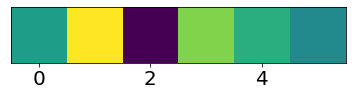

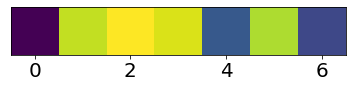

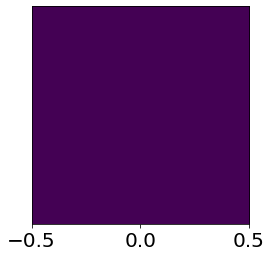

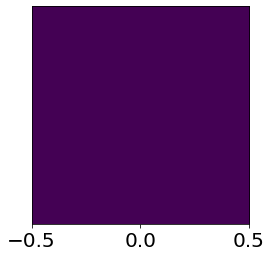

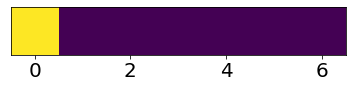

In [2]:
plt.figure("direction") # 图像窗口名称
plt.imshow(direction.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/direction.jpg', dpi=500)
plt.show()

plt.figure("Var") # 图像窗口名称
plt.imshow(Var.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Var.jpg', dpi=500)
plt.show()


plt.figure("direction_sum") # 图像窗口名称
plt.imshow(direction_sum.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/direction_sum.jpg', dpi=500)
plt.show()

plt.figure("Var_sum") # 图像窗口名称
plt.imshow(Var_sum.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Var_sum.jpg', dpi=500)
plt.show()

plt.figure("targets") # 图像窗口名称
plt.imshow(targets.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/targets.jpg', dpi=500)
plt.show()

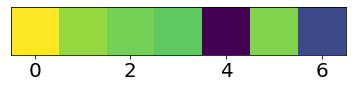

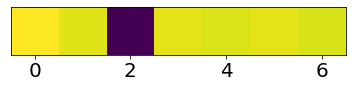

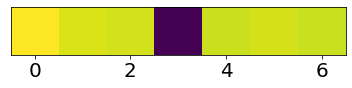

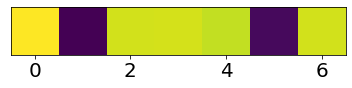

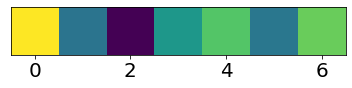

In [3]:
plt.figure("outputs1") # 图像窗口名称
plt.imshow(outputs1.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/outputs1.jpg', dpi=500)
plt.show()

plt.figure("outputs2") # 图像窗口名称
plt.imshow(outputs2.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/outputs2.jpg', dpi=500)
plt.show()

plt.figure("outputs3") # 图像窗口名称
plt.imshow(outputs3.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/outputs3.jpg', dpi=500)
plt.show()

plt.figure("outputs4") # 图像窗口名称
plt.imshow(outputs4.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/outputs4.jpg', dpi=500)
plt.show()

plt.figure("mimic") # 图像窗口名称
plt.imshow(mimic.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/mimic.jpg', dpi=500)
plt.show()

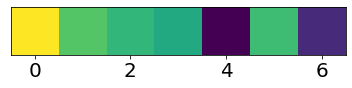

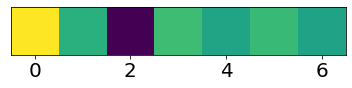

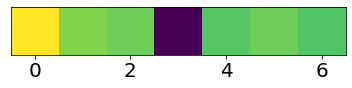

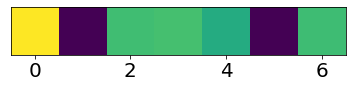

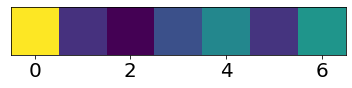

In [4]:
plt.figure("t_outputs1") # 图像窗口名称
plt.imshow(t_outputs1.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/t_outputs1.jpg', dpi=500)
plt.show()

plt.figure("t_outputs2") # 图像窗口名称
plt.imshow(t_outputs2.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/t_outputs2.jpg', dpi=500)
plt.show()

plt.figure("t_outputs3") # 图像窗口名称
plt.imshow(t_outputs3.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/t_outputs3.jpg', dpi=500)
plt.show()

plt.figure("t_outputs4") # 图像窗口名称
plt.imshow(t_outputs4.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/t_outputs4.jpg', dpi=500)
plt.show()

plt.figure("t_mimic") # 图像窗口名称
plt.imshow(t_mimic.cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/t_mimic.jpg', dpi=500)
plt.show()